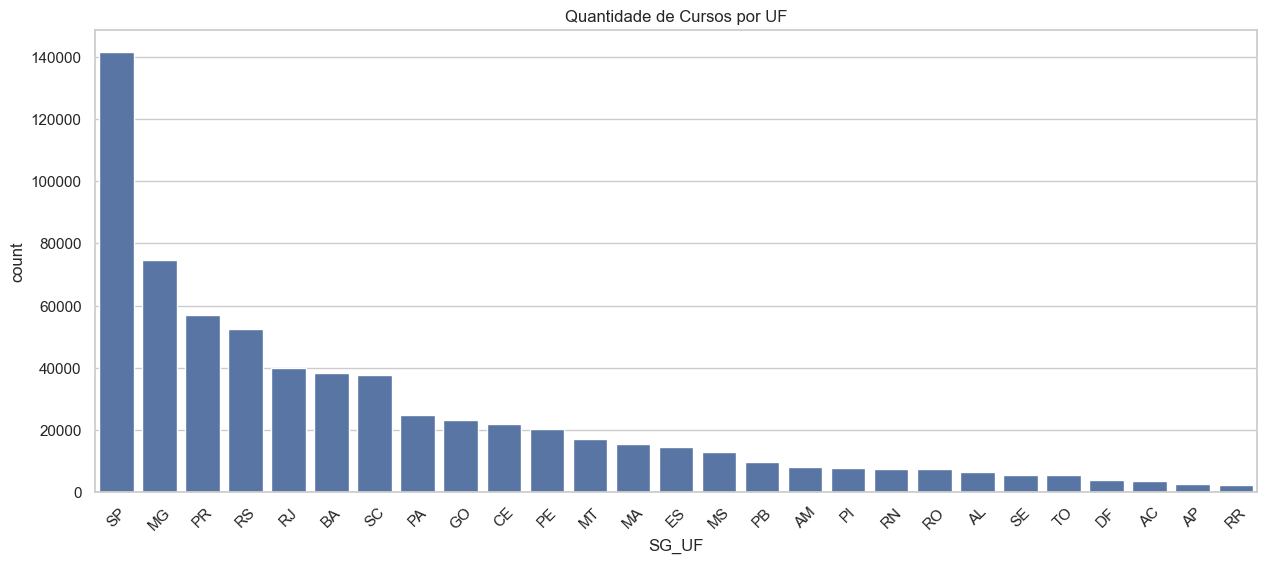


Correlação de Pearson entre número de cursos e bolsistas:
Coeficiente: 0.68 | p-valor: 0.0001

Resumo da Regressão Linear:
                            OLS Regression Results                            
Dep. Variable:              Bolsistas   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     21.94
Date:                Sat, 21 Jun 2025   Prob (F-statistic):           8.46e-05
Time:                        23:23:15   Log-Likelihood:                -265.14
No. Observations:                  27   AIC:                             534.3
Df Residuals:                      25   BIC:                             536.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sqlalchemy import create_engine
from scipy.stats import pearsonr
import statsmodels.api as sm  

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

base_path = '../data/'

file_cursos = base_path + 'MICRODADOS_CADASTRO_CURSOS_2023.CSV'
file_ies = base_path + 'MICRODADOS_ED_SUP_IES_2023.CSV'
file_cnpq = base_path + 'Relatorio_de_dados_abertos_CNPq (1º SEM 2023)(snICJ).xlsx'

df_cursos = pd.read_csv(file_cursos, sep=';', encoding='latin1', low_memory=False)
df_ies = pd.read_csv(file_ies, sep=';', encoding='latin1', low_memory=False)
df_cnpq = pd.read_excel(file_cnpq, skiprows=5)


plt.figure(figsize=(15, 6))
sns.countplot(data=df_cursos, x='SG_UF', order=df_cursos['SG_UF'].value_counts().index)
plt.title('Quantidade de Cursos por UF')
plt.xticks(rotation=45)
plt.show()

uf_counts = df_cursos['SG_UF'].value_counts().reset_index()
uf_counts.columns = ['UF', 'Cursos']
fig = px.bar(
    uf_counts,
    x='UF',
    y='Cursos',
    text_auto=True,
    color='UF',
    title='Cursos por UF',
    width=1000,
    height=500
)
fig.show()


possiveis_cat = ['CATEGORIA_ADMINISTRATIVA', 'TP_CATEGORIA_ADMINISTRATIVA', 'CATEGORIA ADMINISTRATIVA']
col_cat = None
for col in possiveis_cat:
    if col in df_cursos.columns:
        col_cat = col
        break

if col_cat:
    cat_counts = df_cursos[col_cat].value_counts().reset_index()
    cat_counts.columns = ['Categoria', 'Quantidade']
    fig = px.bar(
        cat_counts,
        x='Categoria',
        y='Quantidade',
        text_auto=True,
        color='Categoria',
        title='Cursos por Categoria Administrativa',
        width=800,
        height=500
    )
    fig.show()
else:
    print("Coluna de categoria administrativa não encontrada.")

possiveis_org = ['ORGANIZACAO_ACADEMICA', 'TP_ORGANIZACAO_ACADEMICA', 'ORGANIZAÇÃO ACADÊMICA']
col_org = None
for col in possiveis_org:
    if col in df_cursos.columns:
        col_org = col
        break

if col_org:
    org_counts = df_cursos[col_org].value_counts().reset_index()
    org_counts.columns = ['Organização', 'Quantidade']
    fig = px.bar(
        org_counts,
        x='Organização',
        y='Quantidade',
        text_auto=True,
        color='Organização',
        title='Cursos por Organização Acadêmica',
        width=800,
        height=500
    )
    fig.show()
else:
    print("Coluna de organização acadêmica não encontrada.")

heatmap_data = df_cursos.pivot_table(
    index='SG_UF',
    columns=col_org if col_org else 'SG_UF',
    values='NO_CURSO',
    aggfunc='count',
    fill_value=0
).sort_index()

fig = px.imshow(
    heatmap_data,
    text_auto=True,
    aspect="auto",
    color_continuous_scale='Blues',
    labels=dict(color="Cursos"),
    title="Heatmap: Cursos por UF x Organização Acadêmica",
    width=1000,
    height=600
)
fig.show()

df_cnpq_grouped = df_cnpq.groupby('Sigla UF Destino').size().reset_index(name='Bolsistas')
df_merged = pd.merge(uf_counts, df_cnpq_grouped, left_on='UF', right_on='Sigla UF Destino', how='inner')
df_merged = df_merged[['UF', 'Cursos', 'Bolsistas']].sort_values(by='Cursos', ascending=False)

df_merged_melted = df_merged.melt(id_vars='UF', value_vars=['Cursos', 'Bolsistas'])

fig = px.bar(
    df_merged_melted,
    x='UF',
    y='value',
    color='variable',
    barmode='group',
    text_auto=True,
    labels={'value': 'Quantidade', 'variable': 'Indicador'},
    title="Comparação de Cursos e Bolsistas CNPq por UF",
    width=1000,
    height=600
)
fig.show()


# Correlação de Pearson e Regressão
print("\nCorrelação de Pearson entre número de cursos e bolsistas:")
corr, p_value = pearsonr(df_merged['Cursos'], df_merged['Bolsistas'])
print(f"Coeficiente: {corr:.2f} | p-valor: {p_value:.4f}")

X = df_merged['Cursos']
y = df_merged['Bolsistas']
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
print("\nResumo da Regressão Linear:")
print(model.summary())

print(f"Coeficiente de Determinação (R²): {model.rsquared:.2f}")
print(f"Cada curso adicional se relaciona, em média, a {model.params['Cursos']:.2f} bolsistas a mais.")


